In [1]:
"""
this block is needed at the beginning of all notebooks to be able to load modules
"""
import os
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# Automatically find and append the project root
root_path = Path.cwd().resolve().parents[1]  # adjust level as needed
data_path = os.path.join(root_path, "data")
src_path = os.path.join(root_path, "src")

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

In [2]:
from signal_modules.signal_registry import SignalRegistry
from backtesting.backtester import BacktestEngine
from investor.portfolio_registry import PortfolioRegistry

In [3]:
portfolio_registry = PortfolioRegistry()
portfolio_registry.available()

['default']

In [4]:
default_portfolio = portfolio_registry.get('default')

In [5]:
tickers = ["SPY", "AAPL", "NVDA", "MSFT", "AMZN", "META", "GOOGL", "AVGO", "TSLA", "BRK-B"]  # List of tickers
data = {ticker: pd.read_parquet(os.path.join(data_path, f"{ticker}.parquet")) for ticker in tickers}
data = {tk: df.loc[default_portfolio.initial_time:] for tk, df in data.items()}
data

{'SPY':                             close    high       low    open     volume  \
 date                                                                     
 2024-01-02 00:00:00+00:00  472.65  473.67  470.4900  472.16  123007793   
 2024-01-03 00:00:00+00:00  468.79  471.19  468.1700  470.43  103585866   
 2024-01-04 00:00:00+00:00  467.28  470.96  467.0500  468.30   84232169   
 2024-01-05 00:00:00+00:00  467.92  470.44  466.4300  467.49   85553758   
 2024-01-08 00:00:00+00:00  474.60  474.75  468.3000  468.43   74879074   
 ...                           ...     ...       ...     ...        ...   
 2025-05-12 00:00:00+00:00  582.99  583.00  577.0400  581.47   78993570   
 2025-05-13 00:00:00+00:00  586.84  589.08  582.8400  583.41   67947225   
 2025-05-14 00:00:00+00:00  587.59  588.98  585.5350  587.81   66283531   
 2025-05-15 00:00:00+00:00  590.46  590.97  585.0969  585.56   71268145   
 2025-05-16 00:00:00+00:00  594.20  594.50  589.2800  591.25   71977042   
 
                

In [6]:
signal_registry = SignalRegistry()

In [7]:
signal_registry.available_signals()

['ma_crossover', 'Kalman']

In [8]:
model2 = signal_registry.get('ma_crossover')()
model3 = signal_registry.get('Kalman')()

In [9]:
bt = BacktestEngine(
    data = data, 
    modules_weights = [(model3, 1)], 
    portfolio=default_portfolio
)

In [10]:
bt.run()

Backtesting: 100%|██████████| 345/345 [00:01<00:00, 323.36it/s]


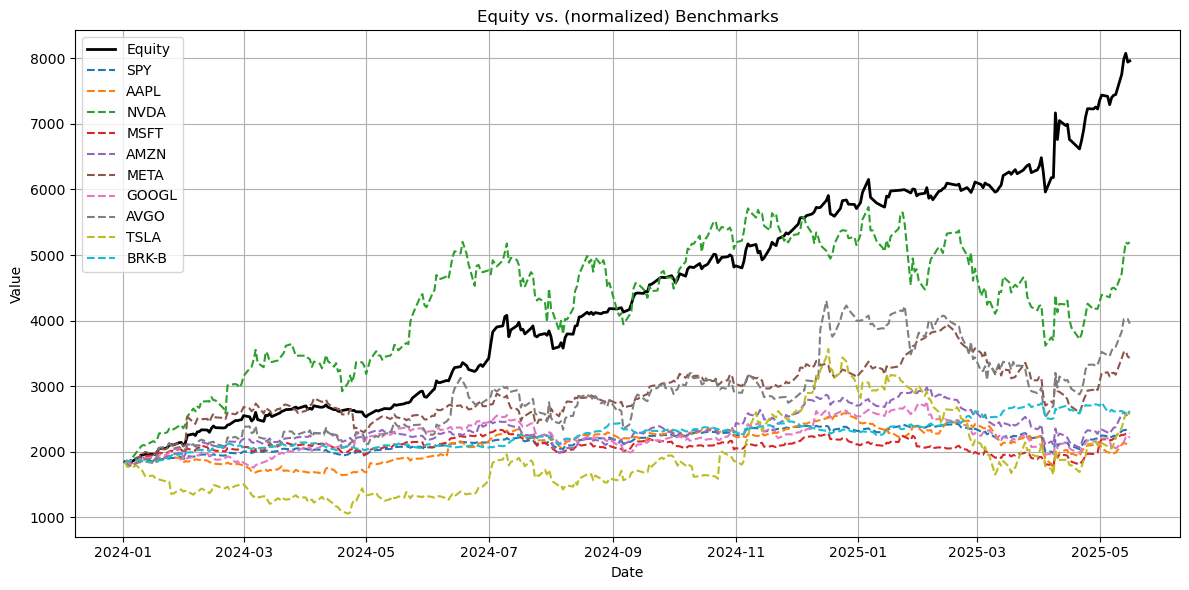

In [11]:
bt.equity_vs_benchmarks(benchmarks=tickers)

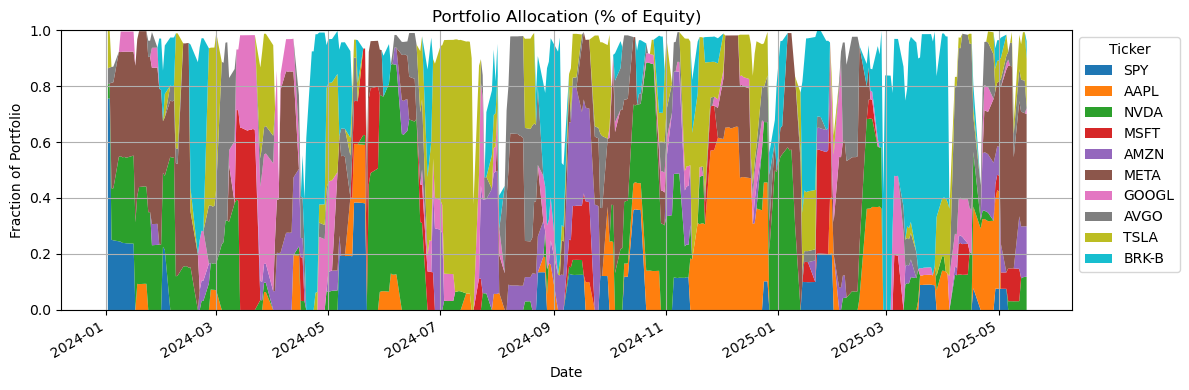

In [12]:
bt.holdings_over_time()